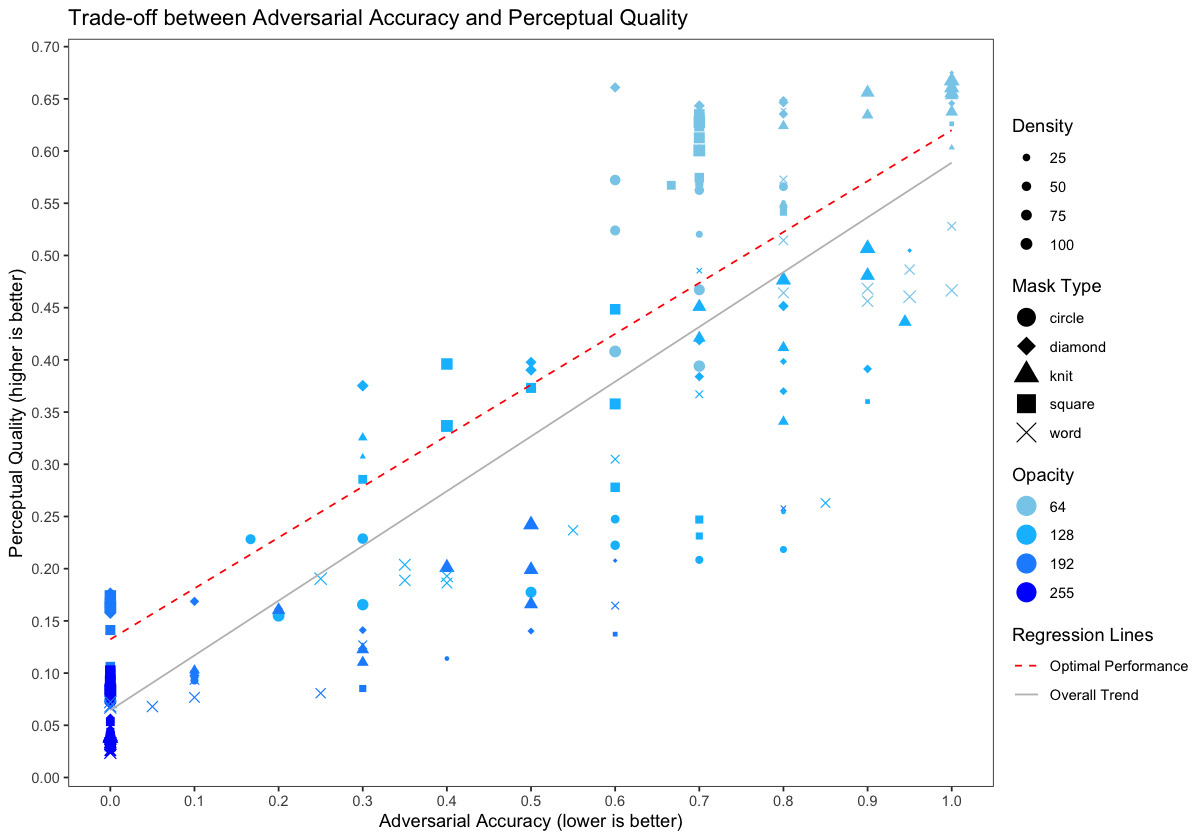

In [5]:
deps <- c("ISLR", "ndjson", "ggplot2", "dplyr", "caret", "tidyr", "gridExtra", "data.table", "repr", "modelr", "splines")
for (p in deps) {
    if (!requireNamespace(p, quietly = TRUE)) {
        install.packages(p, repos = "https://cran.rstudio.com")
    }
    library(p, character.only = TRUE)
}
options(scipen=999)
options(repr.plot.width=10, repr.plot.height=7)

path <- "./eval_cls_mask_density.csv"
data <- data.frame(read.csv(path, header=TRUE, sep=","))

numeric_cols <- sapply(data, is.numeric)
data <- data[!is.infinite(rowSums(data[, numeric_cols])) & !is.na(rowSums(data[, numeric_cols])), ]
data <- unique(data[c('mask', 'opacity', 'density', 'advx_acc1', 'advx_acc5', 'x_acc1', 'x_acc5', 'cosine_sim', 'psnr', 'ssim')])

data <- data %>%
    mutate(
        # metrics
        adv_acc = ((advx_acc1 + advx_acc5) / 2) - ((x_acc1 + x_acc5) / 2) + 1,
        quality = (cosine_sim + psnr / 100 + ssim) / 3
    )

# group by mask, opacity and density
data_grouped <- data %>%
    group_by(mask, opacity, density) %>%
    summarise(
        adv_acc = mean(adv_acc),
        quality = mean(quality),
        .groups = 'drop'
    )

# calculate and add max y values
max_y_data <- data_grouped %>%
    group_by(adv_acc) %>%
    summarise(quality = max(quality))

p <- ggplot(data_grouped, aes(x = adv_acc, y = quality)) +
    geom_point(aes(
        shape = mask,
        color = factor(opacity),
        size = density
    )) +
    geom_smooth(aes(linetype = "Overall Trend"), method = "lm", formula = y ~ poly(x, 1), color = "gray", se = FALSE, size = 0.5) +
    geom_smooth(data = max_y_data, aes(x = adv_acc, y = quality, linetype = "Optimal Performance"), method = "lm", formula = y ~ poly(x, 1), color = "red", se = FALSE, size = 0.5) +
    scale_shape_manual(values = c(
        "word" = 4,     # X
        "circle" = 16,  # filled circle
        "diamond" = 18, # filled diamond
        "square" = 15,  # filled square
        "knit" = 17     # filled triangle
    )) +
    scale_color_manual(values = c(
        "0" = "lightblue",
        "64" = "skyblue",
        "128" = "deepskyblue",
        "192" = "dodgerblue",
        "255" = "blue"
    )) +
    scale_size_continuous(range = c(1, 3)) +
    scale_linetype_manual(
        name = "Regression Lines",
        values = c("Optimal Performance" = "dashed", "Overall Trend" = "solid")
    ) +
    labs(
        x = "Adversarial Accuracy (lower is better)",
        y = "Perceptual Quality (higher is better)",
        title = "Trade-off between Adversarial Accuracy and Perceptual Quality",
        shape = "Mask Type",
        color = "Opacity",
        size = "Density"
    ) +
    guides(
        shape = guide_legend(override.aes = list(size = 5)),
        color = guide_legend(override.aes = list(size = 5)),
        size = guide_legend(override.aes = list(shape = 16)),
        linetype = guide_legend(override.aes = list(color = c("red", "gray")))
    ) +
    theme(
        legend.position = "right",
    ) +
    scale_x_continuous(breaks = seq(0, 1, by = 0.1)) +
    scale_y_continuous(breaks = seq(0, 1, by = 0.05)) +
    theme_test()

print(p)
ggsave("./eval_cls_mask_density.pdf", plot = p, device = "pdf", width = 10, height = 7, units = "in")